# Titanic EDA Notebook
`train.csv` を使い、欠損の多さや基本的な統計を確認。

# データ読み込み

In [30]:
import pandas as pd
train = pd.read_csv("portfolios/Titanic/data/train.csv")
test = pd.read_csv("portfolios/Titanic/data/test.csv")

print(train.head())
print(train.info())
print(train.shape)
print(train.describe())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
<c

# 欠損値の確認

In [31]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Ageの欠損を中央値で埋める
# Cabin（客室番号）の欠損が非常に多いため、
# 本来のCabin文字列は使用せず、「Cabin情報が存在したかどうか（1/0）」のみを新しい特徴量として扱う。
# その後、元のCabin列は削除して、不要な情報を整理する。
# Embarkedの欠損を最頻値で埋める

In [32]:
# Ageの欠損を中央値で埋める
train['Age'] = train.groupby(['Pclass','Sex'])['Age'].transform(lambda x: x.fillna(x.median()))

# Cabin（客室番号）の欠損が非常に多いため、
# 本来のCabin文字列は使用せず、「Cabin情報が存在したかどうか（1/0）」のみを新しい特徴量として扱う。
# その後、元のCabin列は削除して、不要な情報を整理する。
train['Cabin_known'] = train['Cabin'].notnull().astype(int)
train = train.drop('Cabin', axis=1)

# Embarkedの欠損を最頻値で埋める
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])


#欠損値確認

In [33]:
train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Cabin_known    0
dtype: int64

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 性別ごとの生存率
sex_survived = train.groupby('Sex')['Survived'].mean()

# 2. 客室クラスごとの生存率
Pclass_survived = train.groupby('Pclass')['Survived'].mean()

# 3. 年齢ごとの生存率
train['Age_group'] = train['Age'].apply(lambda x: 'child' if x < 8 else 'adult')
Age_group_survived = train.groupby('Age_group')['Survived'].mean()

# 4. 名前から敬称（Title）を取り出して生存率
# Titleごとの人数を数える
title_counts = train['Title'].value_counts()
# 30人以上いるTitleだけ抽出
common_titles = title_counts[title_counts >= 30].index
# その中で生存率を計算
filtered_title_survival = train[train['Title'].isin(common_titles)].groupby('Title')['Survived'].mean()


title_survival = train.groupby('Title')['Survived'].mean()
# 5. 乗船港ごとの生存率

embarked_survival = train.groupby('Embarked')['Survived'].mean()
# 6. Cabin情報あり・なしごとの生存率
cabin_survival = train.groupby('Cabin_known')['Survived'].mean()

<function matplotlib.pyplot.show(close=None, block=None)>

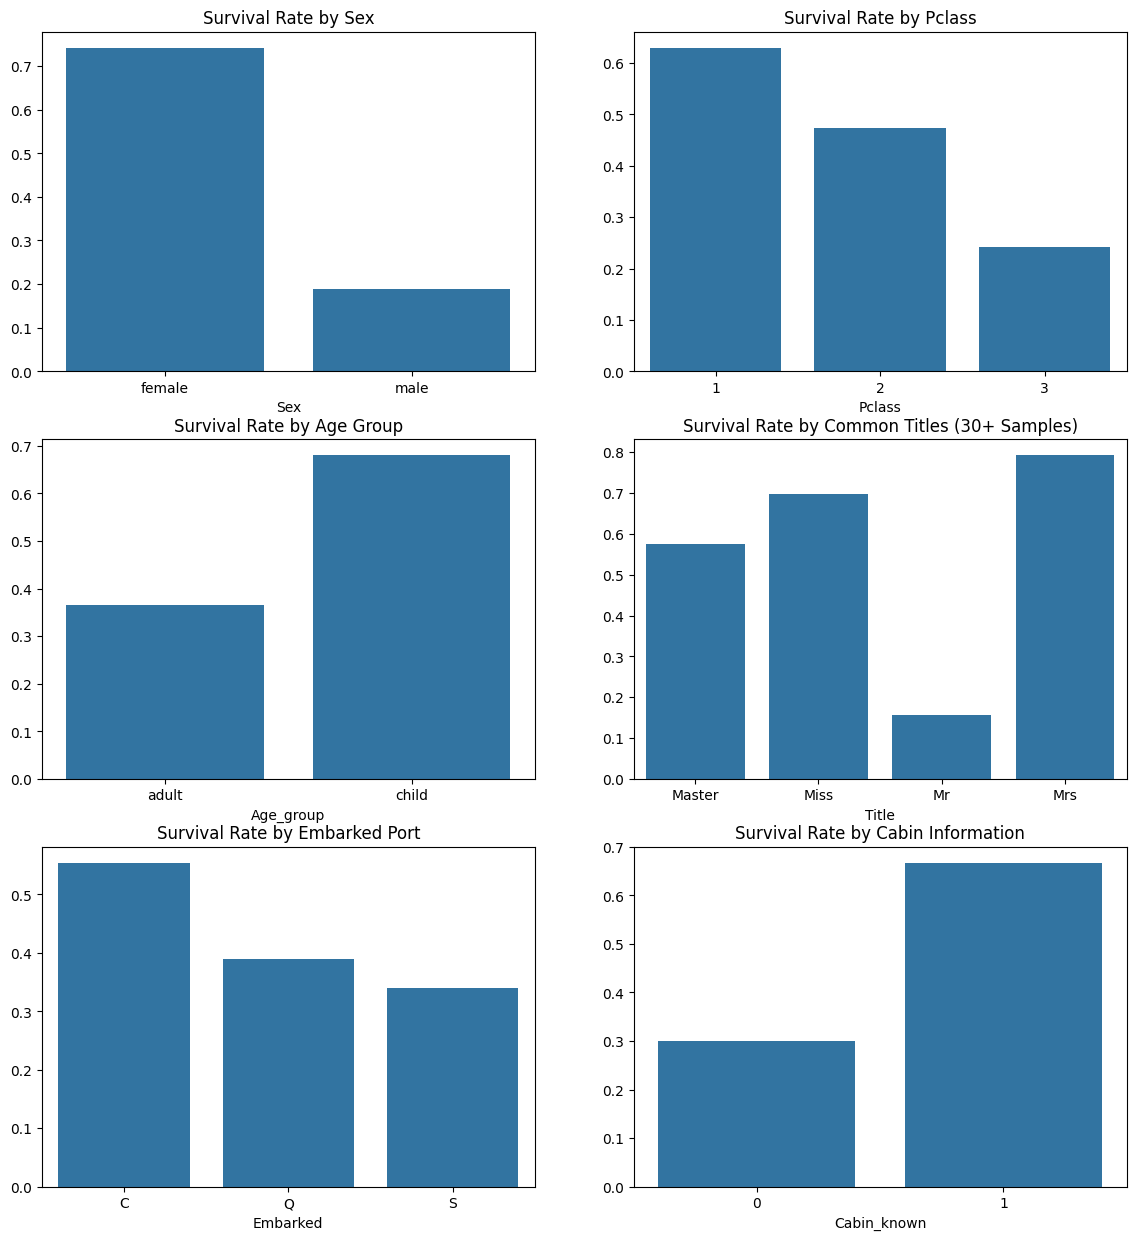

In [67]:
# --- グラフで可視化する ---

fig, axes = plt.subplots(3, 2, figsize=(14, 15))

# 性別ごとの生存率
sns.barplot(x=sex_survived.index, y=sex_survived.values, ax=axes[0,0])
axes[0,0].set_title('Survival Rate by Sex')

#客室クラスごとの生存率
sns.barplot(x=Pclass_survived.index.astype(str), y=Pclass_survived.values, ax=axes[0,1])
axes[0,1].set_title('Survival Rate by Pclass')

#年齢ごとの生存率
sns.barplot(x=Age_group_survived.index, y=Age_group_survived.values, ax=axes[1,0])
axes[1,0].set_title('Survival Rate by Age Group')

#敬称（Title）ごとの生存率
sns.barplot(x=filtered_title_survival.index, y=filtered_title_survival.values, ax=axes[1,1])
axes[1,1].set_title('Survival Rate by Common Titles (30+ Samples)')

# 5. 乗船港ごとの生存率
sns.barplot(x=embarked_survival.index, y=embarked_survival.values, ax=axes[2,0])
axes[2,0].set_title('Survival Rate by Embarked Port')

# 6. Cabin情報あり・なしごとの生存率
sns.barplot(x=cabin_survival.index, y=cabin_survival.values, ax=axes[2,1])
axes[2,1].set_title('Survival Rate by Cabin Information')

#全体のレイアウト
plt.tight_layout
plt.show



In [69]:
# Sexを数値化（male:0, female:1）
train['Sex'] = train['Sex'].map({'male':0,'female':1})

# Embarkedを数値化（C:0, Q:1, S:2）
train['Embarked'] = train['Embarked'].map({'C':0,'Q':1,'S':2})

#Titleをダミー変数化
Title_dummies = pd.get_dummies(train['Title'],prefix='Title')

# 元のtrainにダミー変数を追加
train = pd.concat([train,Title_dummies],axis=1)

# もとのTitle列は不要になったので削除
train = train.drop(columns=['Title'])

In [71]:
features = ['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin_known'] + list(Title_dummies.columns)

X = train[features]
y = train['Survived']

In [74]:
from sklearn.tree import DecisionTreeClassifier

# モデルのインスタンスを作成
model = DecisionTreeClassifier(random_state=42)

# 学習する
model.fit(X, y)

DecisionTreeClassifier(random_state=42)

In [75]:
# モデルの正解率（trainデータに対する）を出す
train_score = model.score(X, y)
print(f"Train Accuracy: {train_score:.4f}")

Train Accuracy: 0.9865


In [76]:
from sklearn.model_selection import train_test_split

# データを学習用とテスト用に分ける
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [89]:
# モデルを新しく作り直す（リセットのため）
model = DecisionTreeClassifier(max_depth=5, random_state=42)

# 学習用データで学習
model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

In [90]:
# テストデータでスコア（精度）をチェック
test_score = model.score(X_test, y_test)
print(f"Test Accuracy: {test_score:.4f}")


Test Accuracy: 0.8268
